In [ ]:
!nvidia-smi

Wed Jun 11 05:45:19 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   44C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import os
HOME = os.getcwd()
print(HOME)

!mkdir {HOME}/models
%cd {HOME}/models

/content
/content/datasets


# Import Dataset from Kaggle

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("deepshah16/silhouettes-of-human-posture")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/silhouettes-of-human-posture


In [ ]:
!pip install tensorflow
!pip install tensorflow seaborn scikit-learn matplotlib

# Full Script for training with Augmentation, Fine-Tuning

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Config
DATASET_DIR = path
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 15
FINE_TUNE_AT = 100  # Layer to start fine-tuning

# Load and split dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_DIR,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
print("Classes:", class_names)

# Optimize dataset pipeline
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1)
])

# Base model (with weights frozen initially)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SIZE + (3,),
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

# Input pipeline
inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = data_augmentation(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

# Compile (initial training)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train (initial, base frozen)
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

# Unfreeze some base model layers for fine-tuning
base_model.trainable = True
for layer in base_model.layers[:FINE_TUNE_AT]:
    layer.trainable = False

# Recompile with lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune training
fine_tune_epochs = 5
total_epochs = EPOCHS + fine_tune_epochs
history_fine = model.fit(train_ds,
                         validation_data=val_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1])

# Save model
model.save('my_model.keras')

Found 4800 files belonging to 4 classes.
Using 3840 files for training.
Found 4800 files belonging to 4 classes.
Using 960 files for validation.
Classes: ['bending', 'lying', 'sitting', 'standing']
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/15
120/120 ━━━━━━━━━━━━━━━━━━━━ 30s 83ms/step - accuracy: 0.6204 - loss: 1.0000 - val_accuracy: 0.8583 - val_loss: 0.3799
Epoch 2/15
120/120 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.8120 - loss: 0.4967 - val_accuracy: 0.8448 - val_loss: 0.3724
Epoch 3/15
120/120 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - accuracy: 0.8458 - loss: 0.4376 - val_accuracy: 0.8687 - val_loss: 0.3331
Epoch 4/15
120/120 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - accuracy: 0.8343 - loss: 0.4360 - val_accuracy: 0.8917 - val_loss: 0.3053
Epoch 5/15
120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - accuracy: 0.8624 - loss: 0.3787 - val_accuracy: 0.8979 - val_loss: 0.3097
Epoch 6/15
120/120 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - accuracy: 0.8499 - loss: 0.4097 - val_accuracy: 0.89

Model saved as 'silhouette_classifier_tf_augmented.h5'


# Plot Accuracy and Loss

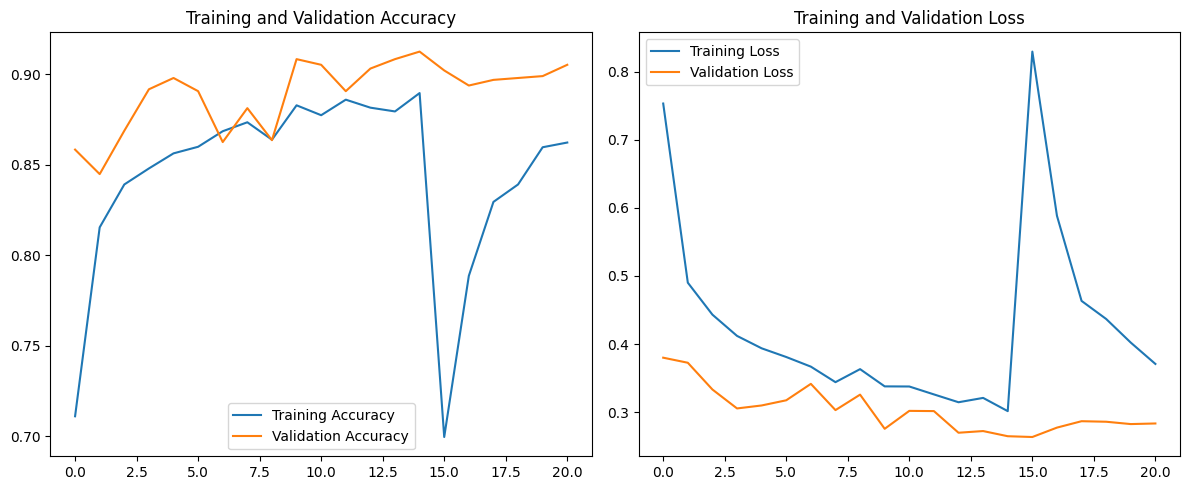

In [ ]:
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']
total_epochs = len(acc)  # Instead of manually setting
epochs_range = range(total_epochs)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

# Confusion Matrix

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━

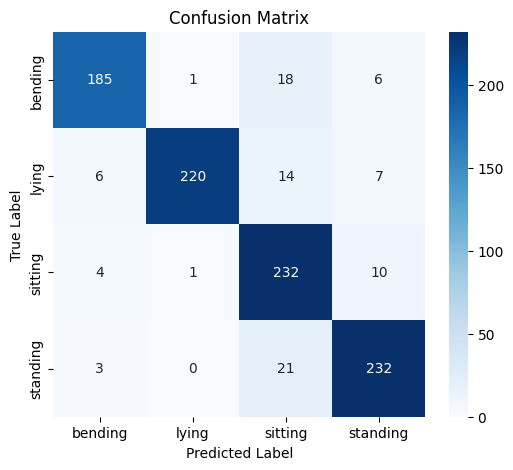


Classification Report:

              precision    recall  f1-score   support

     bending       0.93      0.88      0.91       210
       lying       0.99      0.89      0.94       247
     sitting       0.81      0.94      0.87       247
    standing       0.91      0.91      0.91       256

    accuracy                           0.91       960
   macro avg       0.91      0.90      0.91       960
weighted avg       0.91      0.91      0.91       960



In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Load model
model = tf.keras.models.load_model("my_model.keras")

# Predict and collect labels
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

